# D2O Delta Sharing - Recipient Demo

## Overview
This notebook demonstrates how to access Databricks Delta Sharing data as an **open recipient** (non-Databricks user). 

In this demo, we'll:
1. Load credentials from the config file
2. Connect to the Delta Share
3. List available shares and tables
4. Query the shared data using pandas
5. Create visualizations using seaborn

**Prerequisites:**
- The provider has created a share and recipient
- You have received the credential file (`config.share`)
- This notebook is running in a Docker container with the necessary libraries

## Step 1: Import Required Libraries

In [1]:
import delta_sharing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import warnings

# Configure matplotlib and seaborn
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")
print(f"Delta Sharing version: {delta_sharing.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Libraries imported successfully
Delta Sharing version: 1.3.3
Pandas version: 2.3.3


## Step 2: Load Delta Sharing Credentials

The credentials are mounted as a file at `/tmp/config.share` when running the Docker container.

In [2]:
# Path to the mounted credential file
config_file_path = '/tmp/config.share'

# Create a SharingClient using the mounted config file
client = delta_sharing.SharingClient(config_file_path)

print("✓ Delta Sharing client initialized successfully")
print(f"✓ Using config from: {config_file_path}")

✓ Delta Sharing client initialized successfully
✓ Using config from: /tmp/config.share


## Step 3: List Available Shares

Let's discover what shares are available to us.

In [14]:
# List all available shares
shares = client.list_shares()

print(f"✓ Found {len(shares)} share(s)\n")
for share in shares:
    print(f"Share: {share.name}")
    if hasattr(share, 'id'):
        print(f"  ID: {share.id}")

✓ Found 1 share(s)

Share: external_retail


## Step 4: List Schemas in the Share

Now let's see what schemas (databases) are available in the share.

In [4]:
# Get the first share (assuming it's the external_retail share)
share_name = shares[0].name
print(f"Working with share: {share_name}\n")

# List schemas in the share
schemas = client.list_schemas(delta_sharing.Share(name=share_name))

print(f"✓ Found {len(schemas)} schema(s)\n")
for schema in schemas:
    print(f"Schema: {schema.name}")
    if hasattr(schema, 'share'):
        print(f"  Share: {schema.share}")

Working with share: external_retail

✓ Found 1 schema(s)

Schema: retail
  Share: external_retail


## Step 5: List Tables in the Schema

Let's see what tables are available for us to query.

In [5]:
# Get the first schema
schema_name = schemas[0].name
print(f"Working with schema: {schema_name}\n")

# List all tables in the schema
tables = client.list_tables(delta_sharing.Schema(name=schema_name, share=share_name))

print(f"✓ Found {len(tables)} table(s)\n")
for i, table in enumerate(tables, 1):
    print(f"{i}. Table: {table.name}")
    if hasattr(table, 'share'):
        print(f"   Share: {table.share}")
    if hasattr(table, 'schema'):
        print(f"   Schema: {table.schema}")
    print()

Working with schema: retail

✓ Found 2 table(s)

1. Table: customers
   Share: external_retail
   Schema: retail

2. Table: sales_transactions
   Share: external_retail
   Schema: retail



## Step 6: Query the Customers Table

Let's load the customers table into a pandas DataFrame and explore the data.

In [15]:
# Construct table URL for customers
customers_table_url = f"{config_file_path}#{share_name}.{schema_name}.customers"

# Load the table into a pandas DataFrame
print("Loading customers table...")
customers_df = delta_sharing.load_as_pandas(customers_table_url)

print(f"✓ Loaded {len(customers_df)} customer records\n")

print("\nFirst few records:")
customers_df.head()

Loading customers table...
✓ Loaded 8 customer records


First few records:


,customer_id,customer_name,email,country,signup_date,customer_segment
0,1,Acme Corp,contact@acme.com,USA,2023-01-15,Enterprise
1,2,TechStart Inc,info@techstart.com,Canada,2023-02-20,SMB
2,3,Global Solutions,hello@globalsol.com,UK,2023-03-10,Enterprise
3,4,Innovate Ltd,contact@innovate.com,Australia,2023-04-05,Mid-Market
4,5,Data Dynamics,team@datadyn.com,Germany,2023-05-12,Enterprise


## Step 7: Query the Sales Transactions Table

Now let's load the sales transactions data.

In [16]:
# Construct table URL for sales transactions
sales_table_url = f"{config_file_path}#{share_name}.{schema_name}.sales_transactions"

# Load the table into a pandas DataFrame
print("Loading sales transactions table...")
sales_df = delta_sharing.load_as_pandas(sales_table_url)

print(f"✓ Loaded {len(sales_df)} transaction records\n")

print("\nFirst few records:")
sales_df.head()

Loading sales transactions table...
✓ Loaded 10 transaction records


First few records:


,transaction_id,customer_id,product_name,quantity,unit_price,total_amount,transaction_date,region
0,101,1,Data Platform License,5,1000.00,5000.00,2024-01-15,North America
1,102,2,Analytics Suite,2,500.00,1000.00,2024-01-20,North America
2,103,3,Data Platform License,10,1000.00,10000.00,2024-02-05,EMEA
3,104,1,Storage Add-on,3,200.00,600.00,2024-02-10,North America
4,105,4,Analytics Suite,5,500.00,2500.00,2024-02-15,APAC


## Step 9: Visualization 1 - Transaction Distribution per Customer

Let's create a histogram showing the distribution of transactions per customer.

## Step 10: Visualization 2 - Revenue by Customer Segment

Let's join customers and sales data to analyze revenue patterns by customer segment.

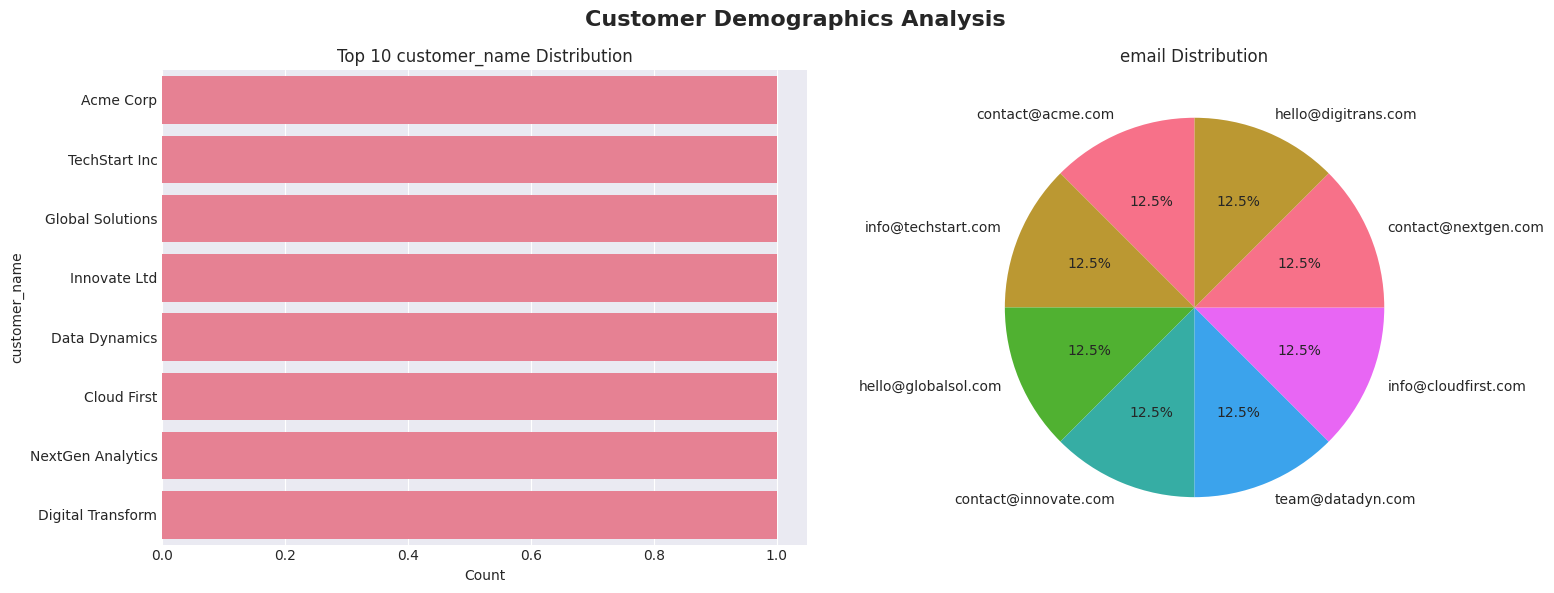

✓ Customer demographics visualizations created


In [ ]:
# Merge customer and sales data
if 'customer_id' in sales_df.columns and 'customer_id' in customers_df.columns:
    merged_df = sales_df.merge(customers_df, on='customer_id', how='left')
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Revenue Analysis by Customer Segment', fontsize=16, fontweight='bold')
    
    # Plot 1: Total revenue by customer segment
    if 'customer_segment' in merged_df.columns and 'total_amount' in merged_df.columns:
        segment_revenue = merged_df.groupby('customer_segment')['total_amount'].sum().sort_values(ascending=True)
        
        # Horizontal bar chart
        colors = ['#e74c3c', '#3498db', '#2ecc71']
        sns.barplot(x=segment_revenue.values, y=segment_revenue.index, palette=colors, ax=axes[0])
        axes[0].set_xlabel('Total Revenue ($)', fontsize=12)
        axes[0].set_ylabel('Customer Segment', fontsize=12)
        axes[0].set_title('Total Revenue by Segment', fontsize=13, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(segment_revenue.values):
            axes[0].text(v + max(segment_revenue.values) * 0.02, i, f'${v:,.0f}', 
                        va='center', fontsize=10, fontweight='bold')
        
        # Plot 2: Average transaction value by segment with transaction count
        segment_stats = merged_df.groupby('customer_segment').agg({
            'total_amount': ['mean', 'count']
        }).round(2)
        segment_stats.columns = ['avg_amount', 'txn_count']
        segment_stats = segment_stats.sort_values('avg_amount', ascending=True)
        
        # Create bar plot with different colors
        bars = axes[1].barh(segment_stats.index, segment_stats['avg_amount'], color=colors)
        axes[1].set_xlabel('Average Transaction Value ($)', fontsize=12)
        axes[1].set_ylabel('Customer Segment', fontsize=12)
        axes[1].set_title('Avg Transaction Value by Segment', fontsize=13, fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels with transaction count
        for i, (val, count) in enumerate(zip(segment_stats['avg_amount'].values, segment_stats['txn_count'].values)):
            axes[1].text(val + max(segment_stats['avg_amount'].values) * 0.02, i, 
                        f'${val:,.0f}\n({int(count)} txns)', 
                        va='center', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*70)
        print("REVENUE SUMMARY BY CUSTOMER SEGMENT")
        print("="*70)
        summary = merged_df.groupby('customer_segment').agg({
            'total_amount': ['sum', 'mean', 'count'],
            'customer_id': 'nunique'
        }).round(2)
        summary.columns = ['Total Revenue', 'Avg Transaction', 'Transactions', 'Unique Customers']
        summary['Revenue per Customer'] = (summary['Total Revenue'] / summary['Unique Customers']).round(2)
        summary = summary.sort_values('Total Revenue', ascending=False)
        
        for segment in summary.index:
            print(f"\n{segment}:")
            print(f"  Total Revenue:        ${summary.loc[segment, 'Total Revenue']:>12,.2f}")
            print(f"  Avg Transaction:      ${summary.loc[segment, 'Avg Transaction']:>12,.2f}")
            print(f"  Total Transactions:    {summary.loc[segment, 'Transactions']:>12.0f}")
            print(f"  Unique Customers:      {summary.loc[segment, 'Unique Customers']:>12.0f}")
            print(f"  Revenue per Customer: ${summary.loc[segment, 'Revenue per Customer']:>12,.2f}")
        
        print("\n" + "="*70)
        print("✓ Revenue analysis visualizations created successfully")
    else:
        axes[0].text(0.5, 0.5, 'Required columns not found', ha='center', va='center')
        axes[1].text(0.5, 0.5, 'Required columns not found', ha='center', va='center')
        plt.show()
else:
    print("Cannot create visualization - customer_id column not found in both tables")
    print(f"Sales columns: {sales_df.columns.tolist()}")
    print(f"Customer columns: {customers_df.columns.tolist()}")

## Step 11: Data Quality Check

Let's verify the data integrity of our merged dataset.

In [ ]:
# Verify merge quality
if 'customer_id' in sales_df.columns and 'customer_id' in customers_df.columns:
    merged_df = sales_df.merge(customers_df, on='customer_id', how='left')
    
    print("DATA QUALITY METRICS")
    print("="*70)
    print(f"Total sales records:              {len(sales_df):>10,}")
    print(f"Total customer records:           {len(customers_df):>10,}")
    print(f"Merged records:                   {len(merged_df):>10,}")
    print(f"Unique customers in sales:        {sales_df['customer_id'].nunique():>10,}")
    print(f"Unique customers in master data:  {customers_df['customer_id'].nunique():>10,}")
    print(f"\nMissing customer info (nulls):    {merged_df['customer_name'].isna().sum():>10,}")
    print(f"Data completeness:                {(1 - merged_df['customer_name'].isna().sum()/len(merged_df))*100:>9.1f}%")
    print("="*70)
    
    # Show sample of merged data
    print("\n✓ Sample merged data:")
    display_cols = ['customer_name', 'customer_segment', 'product_name', 'total_amount', 'region']
    available_cols = [col for col in display_cols if col in merged_df.columns]
    print(merged_df[available_cols].head(10).to_string(index=False))
    
    print("\n✓ Data quality check complete")
else:
    print("Cannot perform quality check - customer_id not found in both datasets")

✓ Merged dataset created with 10 records

Merged columns: ['transaction_id', 'customer_id', 'product_name', 'quantity', 'unit_price', 'total_amount', 'transaction_date', 'region', 'customer_name', 'email', 'country', 'signup_date', 'customer_segment']


## Summary

🎉 **Demo Complete!**

In this notebook, we successfully demonstrated D2O (Databricks-to-Open) Delta Sharing as a recipient:

✅ **What we accomplished:**
1. Loaded credentials from environment variable
2. Connected to the Delta Sharing endpoint
3. Listed available shares, schemas, and tables
4. Queried shared data using pandas
5. Performed data analysis and generated summary statistics
6. Created multiple visualizations using seaborn and matplotlib
7. Merged datasets for advanced analytics

**Key Benefits of D2O Delta Sharing:**
- 🚀 **No Data Duplication**: Access live data without copying
- 🔒 **Secure**: Token-based authentication
- ⚡ **Real-time**: Always get the latest data from provider
- 💰 **Cost-effective**: No storage costs for recipients
- 🛠️ **Tool Agnostic**: Use any tool that supports Delta Sharing (Python, Power BI, Tableau, etc.)
- 🌐 **Open Standard**: Based on open Delta Sharing protocol

**Next Steps:**
- Explore more complex queries and aggregations
- Integrate with your existing data pipelines
- Build dashboards using Power BI or other BI tools
- Set up automated reporting workflows

## 📚 Additional Resources

### Documentation
- **[START-HERE.md](../START-HERE.md)** - Quick navigation guide
- **[README-D2O-DEMO.md](../README-D2O-DEMO.md)** - Complete setup instructions
- **[QUICKSTART-D2O.md](../QUICKSTART-D2O.md)** - Quick reference card
- **[ARCHITECTURE-D2O.md](../ARCHITECTURE-D2O.md)** - System architecture
- **[EXPECTED-OUTPUT.md](../EXPECTED-OUTPUT.md)** - What to expect

### External Links
- [Databricks Delta Sharing Docs](https://docs.databricks.com/delta-sharing/)
- [Delta Sharing Protocol](https://github.com/delta-io/delta-sharing)
- [Python delta-sharing Library](https://github.com/delta-io/delta-sharing/tree/main/python)

### Troubleshooting
If you encounter issues:
1. Check container logs: `docker logs d2o-demo`
2. Verify token expiration in config.share
3. Review provider notebook for share/recipient setup
4. See troubleshooting section in README-D2O-DEMO.md

---
**© 2025 Databricks, Inc. All rights reserved.**